# Quantitative Finance project
## Create and manage a fund in order to ourperform the S&P500 and an absolute index

The idea behind the project was the usage of ML prediction in portfolio construction and manage an active portfolio strategy. 

We were given the task to create a portfolio given the equities and compare the results with a benchmark. The equities are US stocks categorized as ESG (aprox 50 tickers). 
The project will be separated in two main strategies, Long Only (LO) with the SPX as a benchmark and Long/Short benchmarked with Eonia +4%. 

We will back test our portfolio in the hope of having a stable and positive Alpha but at the same time keeping a diversified Low Volatility metric. 

In collaboration with :
- Karim Bouhabid
- [Paul Leydier](https://github.com/pleydier)
- [Wenceslas Sanchez](https://github.com/Orlogskapten)
- [Geri Leka](https://github.com/gerileka)

---

*Table content* :

1. [Our approach](#approach)

2. [Long Only strategy](#long)

3. [Long Short strategy](#short)

<a id= "approach"></a>

# Our approach

The following part will introduce our methodology on how used our data input and the work flow behind the prediction. 

At this part of the project we had the returns of each asset and the 10-K* reports of each assets. The best approach was to try and predict the next month price return using the current data. 

The code will act as prediction proxy to our real data. We will implement machine learning models to predict the upcoming returns of the following assets. The idea behind this code will be to run multiple models and get the best model that works for every asset. This method can help on upcoming projects, find the optimal model in the long run for each asset while using tuning of parameters. In this case, tuning is not necessary since there are not enough data points to stretch our models.

The 10-K results were used as input features to predict our returns. To get even more realistic estimates we future shift these financial results by one quarter, for example, we use Q4 results published in late December to estimate price returns in Q1 of the following year. A big challenge for our project was the following dilemma, transform our returns from monthly to quarterly (upscaling) or transform quarterly earnings in monthly (downscaling). 

The choice was made easier by our dataset length. We had approximately 10 years of data so 120 points, if we chose the upscaling method our dataset would have had a length of 40 points, basically not enough for machine learning methods (ML). Ergo, we chose the late method, using the same earnings for three months consecutively, meaning that we would have the same results for Jan/Feb/March. We added also some lagged price returns (max 2 lags). Yes, rolling mean was choice too but using rolling mean with a window of two is not that significant.

Furthermore, we choose a window size of 12 starting points. We train our model on the first 12 months and we predict on the following month. We choose to minimize the MAE, to have a better understanding of our error. 

We predict the (12 + 1) 13th month, and our step size is 1, meaning that our dataset grows in time. The first prediction uses 12 data points, second one uses 13 data points, and the last one uses the (n - 1) data points (n being the length of the dataset).
To be precise the full length of our dataset is n - 2 since we lagged the price by two periods. 

In addition, the code is flexible, by changing the argument, you’ll get the lags you want and the also quarterly data if desired.

In conclusion we obtain for each ticker, the predicted returns, for 105 months. We are using those predictions to construct portfolios.

We have to build 2 strategies, respectively a LO and Long/Short.

Our portfolio construction for Long/Short is really simple : we get the five top predicted returns and we buy them. We assume to get 20% of each assets in our portfolio. And we get the five worst predicted returns to short them (in the same way we short 20%). 

Thus, the predicted returns determine which assets to select, and we can observe in fact the effectif portfolio return. Actually, we are not using special metric to create/select the portfolio.

Yet, we used a totally different approach with the LO strategy. Firstly, we analyse the correlation between our tickers. For each ticker, we looked if he was too correlated to all others. Then, we develop pack of tickers, with the constraint that each ticker into the pack might be low correlated to all others. So, we had 48 packs of low correlated tickers that represent 48 packs of tickers which can gather to build a diversified portfolio.

Thus, we generate 200 portfolios for every pack, containing between 2 and 5 assets. So, we get 200 * 48 = 9.600 portfolios. For each portfolio, we generate 1000 random weigths for all his tickers, and we saved those whom allows to minimise the variance of the portfolio (based on the historical variance/correlation matrix). With the predicted return, we compute the portfolio returns, for the 105 months, and we choose between the 9.600 portfolios the one which maximises the portfolio return divided by his volatility.

Thereby, it allows us to build for 105 months the optimal portfolios based on predictions and the effective returns per period. 

---
_\*A 10-K is a comprehensive report filed annually by public companies about their financial performance._


<a id= "long"></a>

# _Long Only Portfolio Strategy Analyses_

The following notebook will introduce you to a simple performance analyses of our long only strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the SPX and fees are applied annually. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from texttable import Texttable
from scipy.stats import kurtosis, skew
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import scipy
from scipy.stats import skewnorm

import warnings
warnings.filterwarnings("ignore")

data= pd.read_csv("../data/long_only_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['sp500'] = data['sp500']/100
data['effectif'] = data['effectif']/100
data['prediction'] = data['prediction']/100

### A). Quick statistics

In [2]:
t = Texttable()
t.add_rows([['Series', 'Average Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['SPX', str(round(data['sp500'].mean()*100,2))+'%', str(round(data['sp500'].std()*100,2))+'%',
             str(round(kurtosis(data['sp500']),2)),  str(round(skew(data['sp500']),2))], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2)),  str(round(skew(data['effectif']),2))
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['sp500'].mean()*100),5)) 
print('The Excess Return of our Portfolio on average is '+str(ex_ret)+'% compared to our benchmark (SPX)')

+-----------+----------------+-------+----------+----------+
|  Series   | Average Return |  Std  | Kurtosis | Skewness |
+===========+================+=======+==========+==========+
| SPX       | 0.88%          | 3.38% | 0.870    | -0.350   |
+-----------+----------------+-------+----------+----------+
| Portfolio | 1.28%          | 2.8%  | -0.290   | -0.140   |
+-----------+----------------+-------+----------+----------+
The Excess Return of our Portfolio on average is 0.4% compared to our benchmark (SPX)



- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile. 
- Correlation between our series: 49.7%


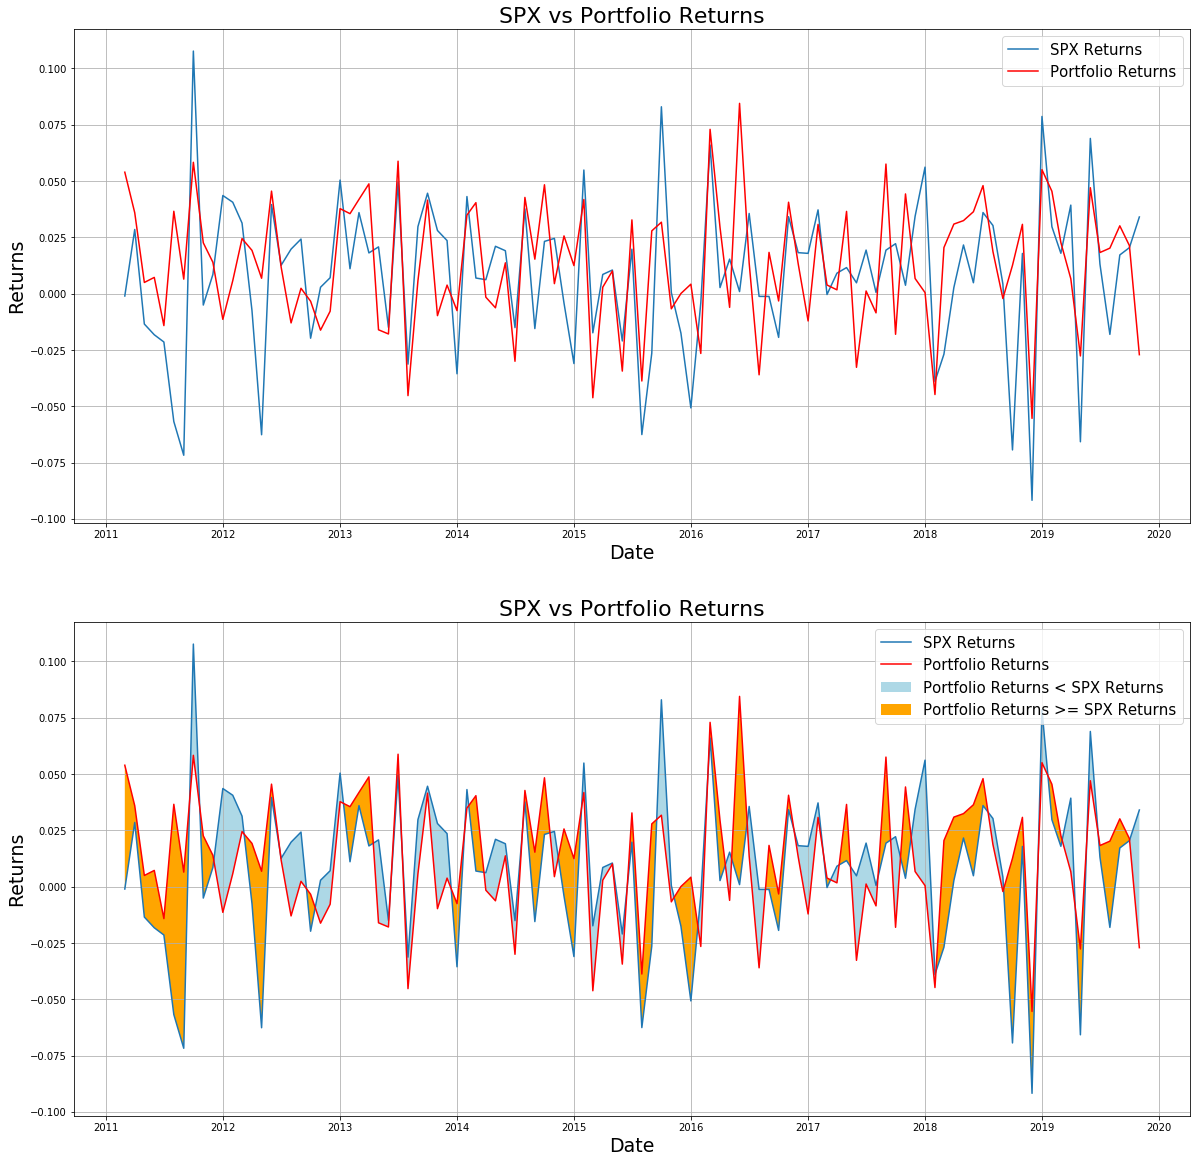

In [3]:
# AX1
fig, ax= plt.subplots(2, 1, figsize= (20, 20))

ax[0].plot(data.date, data.sp500, label='SPX Returns')
ax[0].plot(data.date, data.effectif, c='r', label='Portfolio Returns')

ax[0].set_title('SPX vs Portfolio Returns', size = 22)
ax[0].set_xlabel('Date', fontsize=19)
ax[0].set_ylabel('Returns', fontsize=19)
ax[0].legend(prop={'size': 15})
ax[0].grid()

ax[1].plot(data.date, data.sp500, label='SPX Returns')
ax[1].plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# AX2
# If our portfolio return is above SP, then color the area between SP and portfolio return in tomato
# else fill with lightblue
ax[1].fill_between(data["date"], data["sp500"], data["effectif"]
                , where= data["sp500"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < SPX Returns")
ax[1].fill_between(data["date"], data["sp500"], data["effectif"]
                , where= data["sp500"] <= data["effectif"]
                , facecolor= "orange"
                , interpolate= True
                , label= "Portfolio Returns >= SPX Returns")

ax[1].set_title('SPX vs Portfolio Returns', size = 22)
ax[1].set_xlabel('Date', fontsize=19)
ax[1].set_ylabel('Returns', fontsize=19)
ax[1].legend(prop={'size': 15})
ax[1].grid()

print('\n- The chart shows the difference in volatility of our two series, clearly the SPX is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')

plt.show()

### B). Notes about normality distribution, random walk and extreme returns

In [4]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Frequency", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

##### Here we show the normality and the skewed normality distribution of the SPX and our portfolio. The first chart represent the portfolio distribution and the second one is from the SPX.  

                                   Portfolio                                    


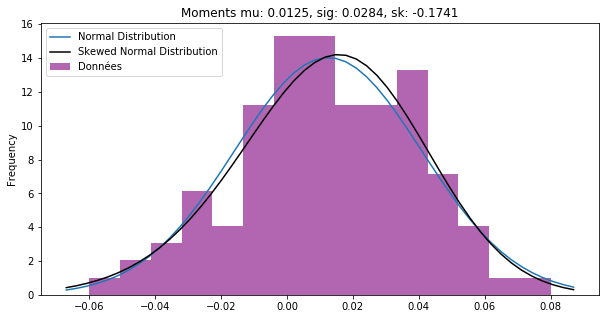


 

                                      SPX                                       


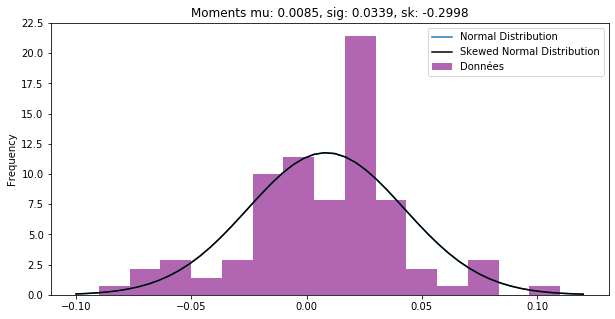

In [5]:
# Our portfolio returns
# warning, we rounded those returns to make the plot more aggragated
print("Portfolio".center(80))
compare_hist_to_norm([round(val, 2) for val in data["effectif"].values], bins= 15)
# SPX distribution
print("\n","\n")
print("SPX".center(80))
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 2) for val in data["sp500"].values], bins= 15)

##### Here we show the Autocorrelation and the Partial Autocorrelation

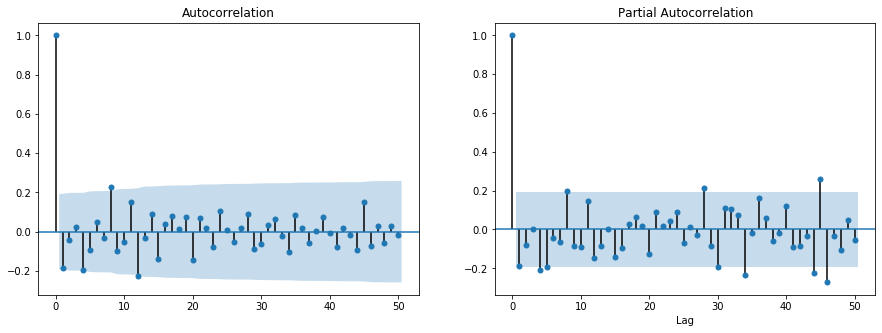

In [6]:
# Autocorrelation for all periods (with confidence intervals)
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(data["effectif"], lags= 50 , ax=ax[0])
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 50,ax=ax[1])
plt.xlabel("Lag")
plt.show()

_Our Portfolio on average outperforms the benchmark with a lower standard deviation (fees not included)._
    
_By the rule of thumb if the skewness is between -0.5 and 0.5, the data are fairly symmetrical ; if the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed ; if the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed. SPX is negatively skewed, and our Portfolio is sim-neg skewed, the reason why we beat our benchmark. This is better shown in the chart above. Indeed, visually we see the difference between the fitted normal distribution and fitted skewed normal distribution for the Portfolio returns which is not observed with the SPX returns distribution. This means that our Portfolio returns distribution are slightly right from the normal one, ergo this explains the good performance of our Portfolio._

_Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values. A large kurtosis is associated with a high level of risk of an investment because it indicates that there are high probabilities of extremely large and extremely small returns. On the other hand, a small kurtosis signals a moderate level of risk because the probabilities of extreme returns are relatively low. 
Note: Scipy Kurtosis is calculated using the the Fisher methods which compares our Kurtosis with the normal one. So the result is calculated using Kurt - 3. Our Portfolio has less extreme events compared to the normal one and the SPX has more extreme ones. This was better shown in the charts shown above, the SPX tails go beyond (fat tails) compared to our Portfolio (SPX goes from -0.1 to 0.1 vs Portfolio -0.06 to 0.08). This was expected just by watching the standard deviation of the returns._

_Finally we think that our dataset is not long enough to get a conclusion about the normality of our returns. We only have 10 years of data (aprox ~ 120 points), which is the limit._ 

_Lastly the ACF (Autocorrelation function) and the PACF (Partial Autocorrelation function) show some signals that we were expecting, for example, we find that the previous month returns are correlated with the current month. In addition we find the lag 4 to also be correlated with the current one, since we down-scaled our 10-K results, we expect correlation between 2 quarters, therefore correlation between 1-6 months. However, the correlations are found to be significant right at the edge of the 5% confidence interval. To conclude, we take those lags as significant so we don't think that we are in the presence of a random walk._ 
   
_All the results are better shown above._

### C). Rolling metrics

In [7]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["sp500"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["sp500"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["sp500"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

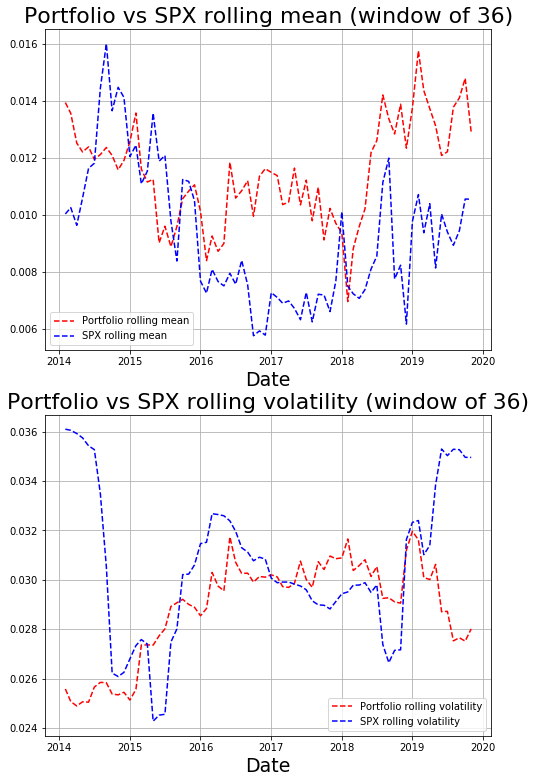

In [8]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (8, 13))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs SPX rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "SPX rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 22)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= "--", color= "blue"
         , label= "SPX rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 22)

for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 19)
    ax[i].grid()
    ax[i].legend()

plt.show()

_Taking a rolling window of 36 points has the following consequence on our returns and volatility of taking into consideration every economical/financial impact from the last 3 years (starting from 2011). As we all know, we are taking into account, Black Monday, European Debt Crisis, Trump election, Brexit etc._

_The impact on the average return will be shown on the stability of our returns. When the SPX goes down, we go down less than the markets and vice versa, when the markets go up, we go even higher. The dream of every PM. Since we are being realistic, we think that the returns that we are having at the beginning of the period is purely by chance since the model was trained with fewer points. As we go along and we add points to our training model, the results are more robust and more real._

_As we mentioned before our Portfolio is less volatile compared to the SPX (on average). Meaning that the impact of financial or economical shocks is lower on our portfolio. For example, the high peak in 2014 of the SPX in volatility, we think is due to Black Monday and the EDC, however our Portfolio is stable but as written before it might be purely by chance. As time passes our volatility follows the market volatility (SPX). We attribute our success of low volatility to one of the constrains applied to the strategy, we tried to maximize $\frac{Portfolio Return}{Porfolio Volatility}$._

### D). Portfolio evaluation

#### 1).

In [9]:
# Applying fees and performance expenses

df = data.copy()

# We transform the annual (1% management fees) to monthly instalments.
fees = (1.01)**(1/12) - 1

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['withfees'] = df['effectif'] - fees

# We create a two lists to iterate for creating slices of dataframe of 10, 11 and 12 months
a = [0] + (list(df[df['month'] == 12].index)) 
b =  (list(df[df['month'] == 12].index)) + [104]

# # The length of the two should match
# len(a) == len(b)

In [10]:
# List that will keep the final values
portfolio_final = []

for l1,l2 in zip(a,b):
    
    # This "if" catches the year that we had only 10 months
    if l2 - l1 < 11:
        
        # It slices the dataframes and it takes the the cumprud of those current slices
        slice_df =  df.iloc[ l1: l2+1]
        spxcpr = (1 + slice_df['sp500'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        # Transforming the excess return fee into monthly instalments.
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(10)) - 1
        
        # If we beat our benchmark, a 20% fee on the excess return is applied monthly.
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)     
        
    # This "if" catches the years that are full 12 months
    elif l2 - l1 == 12:
        
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['sp500'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(12)) - 1

        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)
        
    # This "if" catches the years that we had 11 months
    elif l2 - l1 == 11 : 

        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['sp500'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(11)) - 1
        
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees) 

# Adding the final transformed returns after taking out the management fees and the excess return fee. 
df['final_ppt'] = np.concatenate(portfolio_final, axis=0)
data2= df.copy()

In [11]:
t = Texttable()
t.add_rows([['Series', 'Total Return' ,'Annualized Total Return' ], 
            ['SPX', str(round(list((1+data['sp500']).cumprod())[-1]-1,3)*100)+'%',
            str(round(((1+round(list((1+data['sp500']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'] ,
            
            ['Portfolio (without fees)',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%',
             str(round(((1+round(list((1+data['effectif']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ],
            
            ['Portfolio (with fees)',  str(round(list((1+data2['final_ppt']).cumprod())[-1]-1,3)*100)+'%',
             str(round(((1+round(list((1+data2['final_ppt']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ]
           ])
print(t.draw())

+--------------------------+--------------+-------------------------+
|          Series          | Total Return | Annualized Total Return |
+==========================+==============+=========================+
| SPX                      | 136.7%       | 10.36%                  |
+--------------------------+--------------+-------------------------+
| Portfolio (without fees) | 265.5%       | 15.98%                  |
+--------------------------+--------------+-------------------------+
| Portfolio (with fees)    | 194.4%       | 13.12%                  |
+--------------------------+--------------+-------------------------+


In [12]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Benchmark', 'Alpha' , 'Beta'], 
            ['SPX', str(round(alpha*100,3))+' %',str(round(beta,2))]])
        print(t.draw())
    else:
        return alpha, beta
    
print('The results are shown for the entire period (wihtout fees)')
alpha_beta(data["sp500"].values, data["effectif"].values)

print('\nThe results are shown for the entire period (with fees)')
alpha_beta(data2["sp500"].values, data2["final_ppt"].values)

The results are shown for the entire period (wihtout fees)
+-----------+---------+-------+
| Benchmark |  Alpha  | Beta  |
+===========+=========+=======+
| SPX       | 0.918 % | 0.410 |
+-----------+---------+-------+

The results are shown for the entire period (with fees)
+-----------+-------+-------+
| Benchmark | Alpha | Beta  |
+===========+=======+=======+
| SPX       | 0.7 % | 0.420 |
+-----------+-------+-------+


The fees that were expected to be applied were the following ones:
- Management fees of 1% applied annually
- Performance fees of 20% if the benchmark was beaten annually.

_Starting with management fees we transformed annually fees to monthly installments using $x^{12} = 1.01$ and applied this fee monthly. We tried to do the same with the performance fees but the task was a little bit trickier. We needed to calculate the cumulative product of our series per year meaning that the end of the year will always be December. The following problem appeared, we found that the the first year was only 10 months and the last year was only 11 months, so we thought of using the index of the 12th month to slice our dataset in periods. For each period we calculate the cumprod(annual return) followed by a comparison with the SPX annual return. If our Portfolio performance was higher than the SPX, we deduct 20% of the excess return. So simplify our approach as we said earlier, this fee was applied monthly by transforming it in monthly and recreating the initial returns._

_The results were still interesting because we still managed to beat the benchmark. On total return our Portfolio did 194% vs 136% of the SPX, in addition the Annualized Return was 13% vs 10%. Overall we are really proud of our results since beating SPX with those amazing returns was a challenge, but at the same time we should be realistic since we didn't applied transaction costs (we re-balance our Portfolio monthly). The comparison of the performances can be found below in the chart._

_Regarding the Alpha and the Beta of the two methods, we find some good results. These metrics were found using a linear regression between the Portfolio returns explained by the SPX returns. We took the intercept as the Alpha and the coefficient of the SPX as the Beta. The metrics represent the average monthly Alpha and Beta. The first table shows the results of the Portfolio without fees, and we get an Alpha of 0.9% and the a Beta of 0.4, meaning that we move the same direction as the Market just in a lower scale. Visually it was explained thanks to the charts above showing clearly the standard deviation of our Portfolio vs SPX. Applying the fees our Alpha has been reduced as expected but it still remains positive, however our Beta increases slightly._

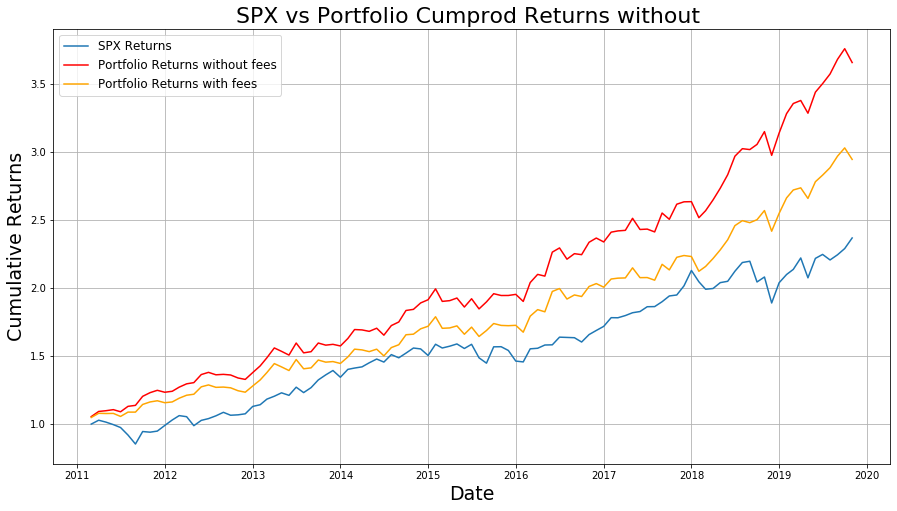

In [13]:
plt.figure(figsize=(15,8))
plt.plot(data.date,(1+data['sp500']).cumprod(),label='SPX Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns without fees')
plt.plot(data2.date,(1+data2['final_ppt']).cumprod(), c='orange', label='Portfolio Returns with fees')
plt.title('SPX vs Portfolio Cumprod Returns without ', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

#### 2).

In [14]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [15]:
roll_alpha = []
roll_beta = []

for be, al in zip((windows(data["sp500"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)

roll_alpha_before= roll_alpha
roll_beta_before= roll_beta

roll_alpha = []
roll_beta = []

for be, al in zip((windows(data2["sp500"], 36, 1)),(windows(data2["final_ppt"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


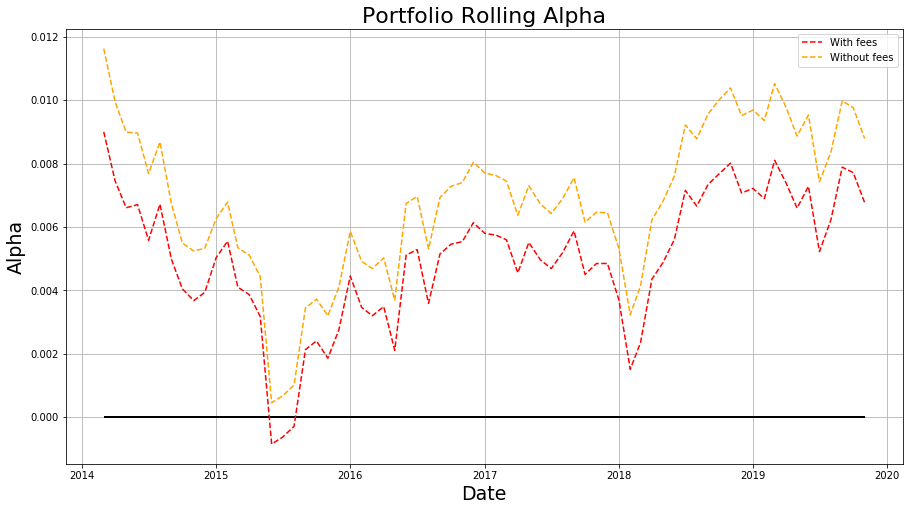

In [16]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_alpha):]
         , roll_alpha, label="With fees"
         , color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_alpha_before):]
         , roll_alpha_before, label='Without fees'
         , color= "orange", linestyle= "--")

plt.hlines(np.repeat(0, len(roll_alpha))
           , xmin= data2.date.values[-len(roll_alpha_before):][0]
           , xmax= data2.date.values[-len(roll_alpha_before):][-1]
           , color= "black"
          )

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36


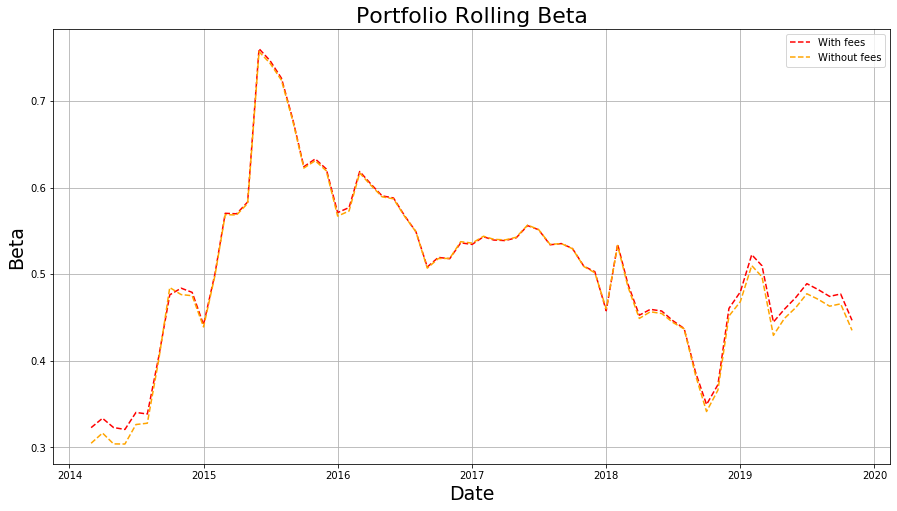

In [17]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_beta):]
         , roll_beta, label='With fees', color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_beta_before):]
         , roll_beta_before, label='Without fees', color= "orange", linestyle= "--")

# plt.vlines(ymin= 0.3, ymax= 0.9, x= "2018")

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Beta with a window of 36')
plt.show()

#### 3).

_Beta, used in capital asset pricing model (CAPM), is a measure of the volatility, or systematic risk, of a security or portfolio, in comparison to the market as a whole. Systematic risk, or market risk, is the volatility that affects many industries, stocks, and assets. Systematic risk affects the overall market and is difficult to predict. Unlike with unsystematic risk, diversification cannot help to smooth systematic risk, because it affects a wide range of assets and securities. [Investopedia](https://www.investopedia.com/ask/answers/040715/there-positive-correlation-between-risk-and-return.asp)_

_Graphically we don't see a difference between our Beta-s of two Portfolios. The following explanation will be the same for both. By watching the chart, our Portfolio keeps a positive Beta, which means it always follows the Market, something expected since our tickers are part of the SPX (like IBM for example). Our Portfolio is sensitive to systematic risk but at different scales between periods. We have a peak in the end of 2015, which is related to the assets that we have in our Portfolio. Unfortunately we don't know which assets impact this, since we are computing a rolling Beta and not the actual one. From 2014 to mid 2015 we observe a peak in our Beta since the market was in a massive bull run from 2010 to late 2015, so we expect (we think) that all the assets were impacted ergo, the high correlation between our Portfolio and the benchmark. However, globally our Beta remains low but we can't have an actual explanation for this observation._



_Alpha is a term used in investing to describe a strategy's ability to beat the market, or it's edge. Alpha is thus also often referred to as excess return or abnormal rate of return._

_Knowing this, a big part of our return comes from the active strategy of selecting assets. Positive Alpha can be generated by exploiting security specific risk. So, the general idea behind our prediction approach was to try predicting the return of each assets by generating a model for each ticker that will use the specificity of each company (the results) to quantify the specific return of the asset. In addition with our portfolio construction strategy, we maximize the return divided by the standard deviation, ergo we will have some sort of diversification that will lower our exposure to specific risk. Finally we output a strategy that it will utilize a well diversified portfolio and create positive alpha._

<a id= "short"></a>

# _Long/Short Strategy Portfolio Analyses_

The following notebook will introduce you a performance analyses of our L/SH strategy for a timeline of 105 months between 2011 and 2019. Our benchmark is the EONIA +4% (per year) and fees are applied annually.

How to spread 4% per year into monthly returns ? We assume that +4% per year = to 0.327% per month ($x^{12}= 1.04 \iff x= 0.00327$). Then, we add this constant float to EONIA monthly rates. We will call this new series EONIA4.

In [18]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from texttable import Texttable
# from scipy.stats import kurtosis, skew
# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.graphics.tsaplots import plot_pacf
# import scipy
# from scipy.stats import skewnorm

# import warnings
# warnings.filterwarnings("ignore")

data= pd.read_csv("../data/long_short_return_.csv")
data['date'] = pd.to_datetime(data['date'])
data['eonia_4'] = (data['eonia'].str.replace(',','.').astype(float)/100)+ 0.00327
data['eonia'] = (data['eonia'].str.replace(',','.').astype(float)/100)
data['effectif'] = data['effectif']/100
data['pred'] = data['pred']/100

# SP pour faire des comparaisons marché
data_sp= pd.read_csv("../data/long_only_return_.csv")
data_sp['date'] = pd.to_datetime(data_sp['date'])
data_sp['sp500'] = data_sp['sp500']/100

### A). Quick statistics

In [19]:
t = Texttable()
t.add_rows([['Series', 'Mean Return', 'Std', 'Kurtosis', 'Skewness'], 
            ['EONIA +4%', str(round(data['eonia_4'].mean()*100,2))+'%', str(round(data['eonia_4'].std()*100,2))+'%',
             str(round(kurtosis(data['eonia_4']),2)),  str(round(skew(data['eonia_4']),2))], 
            
            ['Portfolio', str(round(data['effectif'].mean()*100,2))+'%', str(round(data['effectif'].std()*100,2))+'%',
              str(round(kurtosis(data['effectif']),2)),  str(round(skew(data['effectif']),2))
            ]])

print(t.draw())
ex_ret = (round((data['effectif'].mean()*100-data['eonia_4'].mean()*100),3)) 
print('The Excess Return of our Portfolio on average is: '+str(ex_ret)+'% compared to our benchmark (EONIA4)')

+-----------+-------------+-------+----------+----------+
|  Series   | Mean Return |  Std  | Kurtosis | Skewness |
+===========+=============+=======+==========+==========+
| EONIA +4% | 0.29%       | 0.39% | 1.240    | 1.330    |
+-----------+-------------+-------+----------+----------+
| Portfolio | 0.26%       | 4.42% | 1.810    | -0.300   |
+-----------+-------------+-------+----------+----------+
The Excess Return of our Portfolio on average is: -0.034% compared to our benchmark (EONIA4)



- The chart shows the difference in volatility of our two series, clearly our Portfolio is more volatile. 
- Correlation between our series: -9.4%


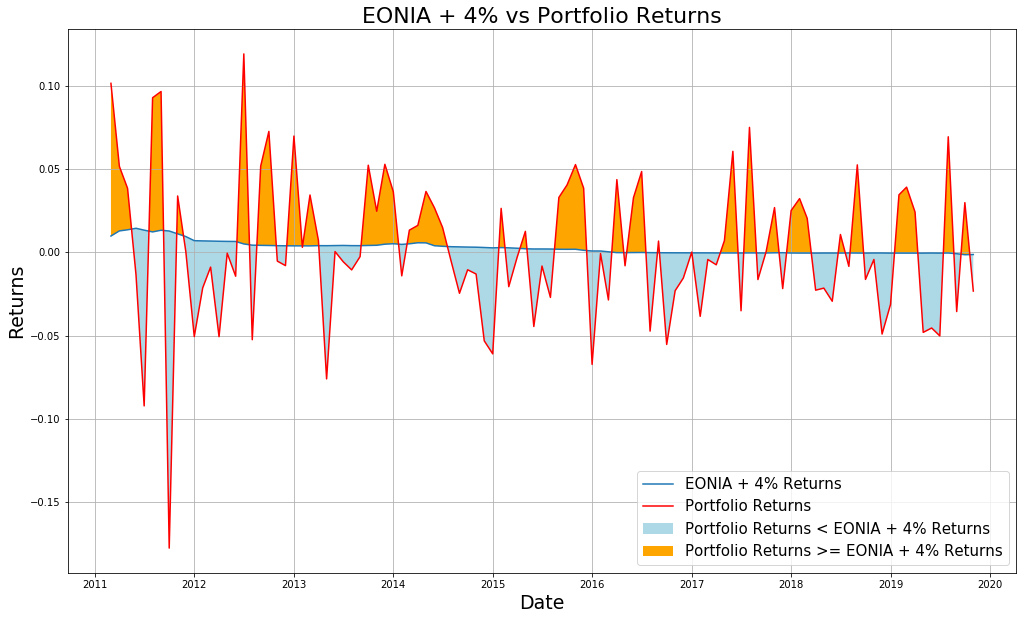

In [20]:
plt.figure(figsize=(17,10))
plt.plot(data.date, data.eonia_4, label='EONIA + 4% Returns')
plt.plot(data.date, data.effectif, c='r', label='Portfolio Returns')

# If our portfolio return is above EONIA + 4%, then color the area between SP and portfolio return in tomato
# else fill with lightblue
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] > data["effectif"]
                , facecolor= "lightblue"
                , interpolate= True
                , label= "Portfolio Returns < EONIA + 4% Returns")
plt.fill_between(data["date"], data["eonia_4"], data["effectif"]
                , where= data["eonia_4"] <= data["effectif"]
                , facecolor= "orange"
                , interpolate= True
                , label= "Portfolio Returns >= EONIA + 4% Returns")


plt.title('EONIA + 4% vs Portfolio Returns', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Returns', fontsize=19)
plt.legend(prop={'size': 15})
plt.grid()
print('\n- The chart shows the difference in volatility of our two series, clearly our Portfolio is more volatile.',
     '\n- Correlation between our series: '+str(round(data.corr().iloc[0,1],3)*100)+'%')
plt.show()

### B). Notes about normality distribution, random walk and extreme returns

In [21]:
# Normality distribution of our returns

def compare_hist_to_norm(data, bins= 25):
    fig= plt.figure(figsize= (10, 5))
    # mu, std, sk, k= scipy.stats.norm.stats(data, moments='mvsk')
    mu, std= scipy.stats.norm.fit(data)
    # params= scipy.stats.norm.fit(data)
    # sk= scipy.stats.skewnorm(data)
    # Plot l'hist
    plt.hist(data, bins= bins, density=True, alpha=0.6,
    color='purple', label= "Données")
    # Plot le PDF.
    
    xmin, xmax= plt.xlim()
    X= np.linspace(xmin, xmax)
    
    plt.plot(X, scipy.stats.norm.pdf(X, mu, std), label= "Normal Distribution")
    plt.plot(X, skewnorm.pdf(X, *skewnorm.fit(data)), color= 'black', label= "Skewed Normal Distribution")
    
    mu, std= scipy.stats.norm.fit(data)
    sk= scipy.stats.skew(data)
    
    title2= "Moments mu: {}, sig: {}, sk: {}".format(round(mu,4), round(std, 4), round(sk, 4))
    plt.ylabel("Fréquence", rotation= 90)
    plt.title(title2)
    plt.legend()
    
    plt.show()

                                   Portfolio                                    


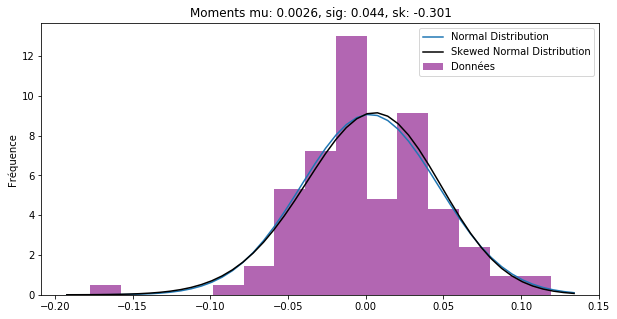


 

                                     EONIA4                                     


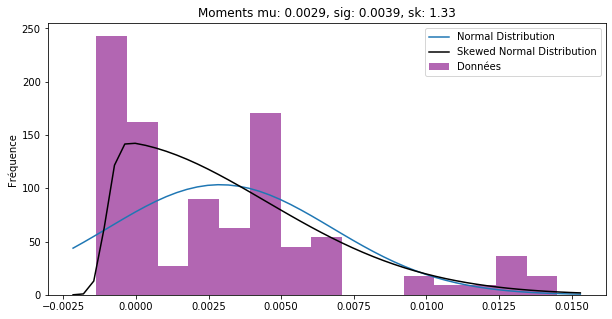

In [22]:
# Our portfolio returns
print("Portfolio".center(80))
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["effectif"].values], bins= 15)

# EONIA distribution
print("\n","\n")
print("EONIA4".center(80))
# warning, we rounded those returns to make the plot more aggragated
compare_hist_to_norm([round(val, 5) for val in data["eonia_4"].values], bins= 15)

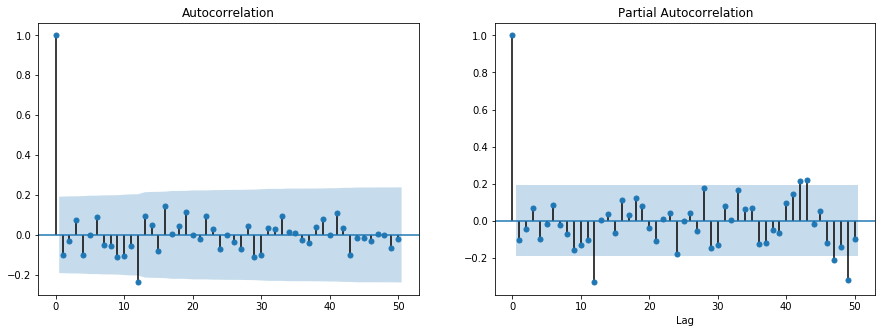

In [23]:
# Autocorrelation for all periods (with confidence intervals)

fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(data["effectif"], lags= 50 , ax=ax[0])
plt.xlabel("Lag")
# partial autocorr
plot_pacf(data["effectif"], lags= 50,ax=ax[1])
plt.xlabel("Lag")
plt.show()

_Our Portfolio on average under-performs the benchmark with a higher standard deviation (fees not included). The EONIA itself has an average return close to 0%, the bump up is pushed thanks to the +4% annually and we find average return found if we transform the 4% monthly. The std is shows a real volatility of our Portfolio since is a real active and risky strategy. Shorting a stock is more difficult then staying long on an asset._

_As we said in the Long Analyses Kurtosis will be compared to the normal distribution. Here both of our series have a positive kurtosis between 1-2, meaning that they will be leptokurtic. In general, leptokurtic distributions have heavier tails or a higher probability of extreme outliers value compared the the normal distribution. Anyway if the benchmark has a lower kurtosis than our Portfolio, meaning that the extreme events will be less frequent._

_Investors note skewness when judging a return distribution because it, like kurtosis, considers the extremes of the data set rather than focusing solely on the average. Here we find a positive skew for the EONIA4, something expected since the negative values were really shown only recently and we have been monthly on the positive side. In the other hand, our Portfolio present negative returns but still symmetrical since is higher than -0.5._

_Both of our series are off, so not even considered as normal even if our datasets gets larger. This can be easily spotted even graphically._ 

_Last but not least the ACF and the PACF shows some correlation with the 12th month lag, being purely by chance. Having also some correlation in the end of the 50 month period we can conclude that we don't have a random walk. (significance at 5%)._ 
   
_All the results are better shown above._

### C). Rolling metrics

In [24]:
# Rolling metrics
window= 36
lag= 1 # for autocorrelation

effectif_rolling_mean= data["effectif"].rolling(window).mean()
effectif_rolling_mean.index= data["date"]
effectif_rolling_std= data["effectif"].rolling(window).std()
effectif_rolling_std.index= data["date"]
effectif_rolling_autocorr= data["effectif"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
effectif_rolling_autocorr.index= data["date"]


sp_rolling_mean= data["eonia_4"].rolling(window).mean()
sp_rolling_mean.index= data["date"]
sp_rolling_std= data["eonia_4"].rolling(window).std()
sp_rolling_std.index= data["date"]
sp_rolling_autocorr= data["eonia_4"].rolling(window).apply(
    lambda row: pd.Series(row).autocorr(lag))
sp_rolling_autocorr.index= data["date"]

# pour le sp
spvrai_rolling_mean= data_sp["sp500"].rolling(window).mean()
spvrai_rolling_mean.index= data_sp["date"]

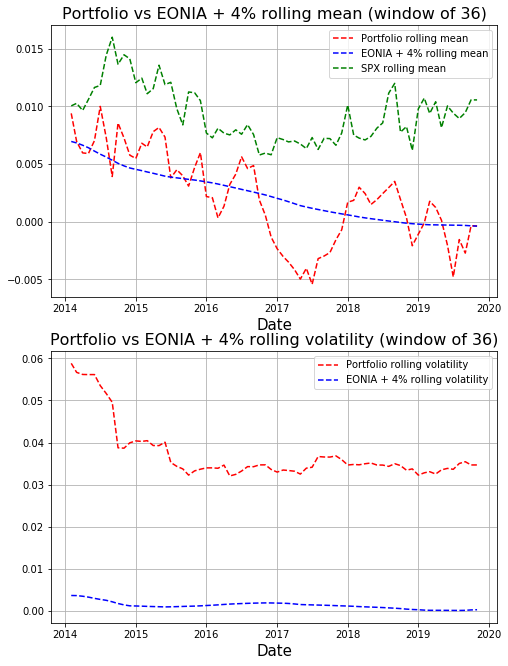

In [36]:
# PLot rolling metrics

# fig= plt.figure(figsize= (20, 30))
ligne= 2
fig, ax= plt.subplots(ligne, 1, figsize= (8, 11))

legend_dico= {0: "mean", 1: "volatility"}
def return_title(i, dic= legend_dico, window= window):
    return "Portfolio vs EONIA + 4% rolling {} (window of {})".format(dic[i], window)

# Rolling mean
mean= return_title(0)
ax[0].plot(effectif_rolling_mean, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[0]))
ax[0].plot(sp_rolling_mean, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[0]))
ax[0].plot(spvrai_rolling_mean, linestyle= "--", color= "green"
         , label= "SPX rolling {}".format(legend_dico[0]))
ax[0].set_title(mean, size= 16)

# Rolling std
std= return_title(1)
ax[1].plot(effectif_rolling_std, linestyle= "--", color= "red"
         , label= "Portfolio rolling {}".format(legend_dico[1]))
ax[1].plot(sp_rolling_std, linestyle= "--", color= "blue"
         , label= "EONIA + 4% rolling {}".format(legend_dico[1]))
ax[1].set_title(std, size= 16)

for i in range(ligne):
    ax[i].set_xlabel("Date", fontsize= 15)
    ax[i].grid()
    ax[i].legend()

plt.show()

_Taking a rolling window of 36 points has the following consequence on our returns and volatility of taking into consideration every economical/financial impact from the last 3 years (starting from 2011). As we all know, we are taking into account, Black Monday, European Debt Crisis, Trump election, Brexit etc._

_We can clearly see the stability versus the big volatility of our Portfolio. Unfortunately this is due to our Long/Short strategy. As mentioned before, it is a real challenge to try and short equities in a Bull Market run. We see a severe downturn in late 2017 but the effects could be earlier. Unfortunately we don't know the equities that are inside the Portfolio during the whole period since we re-balance every month and compute a moving metric._

_The volatility of EONIA4 will always be stable since the real EONIA is always close to zero and around that since 08'. The volatility of our Portfolio starts to stabilize around 2014-2015 when the effects of the Black Monday and EDC starts to disappear, however we remain above EONIA4._

_We added SPX series for the rolling mean, to make it easier our comprehentsion of our Portfolio rolling mean. Indeed, without it, we could think the portfolio return trend is following EONIA4's one. But actually, when we compared it with SPX return trend, we noticed our Portfolio is following the market and not EONIA4. Later, we are going to confirm there is not any link between our Portfolio returns and EONIA4._

### D). Portfolio evaluation

#### 1).

In [26]:
# Applying fees and performance expenses

df = data.copy()

# We transform the annual (1% management fees) to monthly instalments.
fees = (1.01)**(1/12) - 1

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['withfees'] = df['effectif'] - fees

# We create a two lists to iterate for creating slices of dataframe of 10, 11 and 12 months
a = [0] + (list(df[df['month'] == 12].index)) 
b =  (list(df[df['month'] == 12].index)) + [104]

# # The length of the two should match
# len(a) == len(b)

In [27]:
# List that will keep the final values
portfolio_final = []

for l1,l2 in zip(a,b):
    
    # This "if" catches the year that we had only 10 months
    if l2 - l1 < 11:
        
        # It slices the dataframes and it takes the the cumprud of those current slices
        slice_df =  df.iloc[ l1: l2+1]
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        # Transforming the excess return fee into monthly instalments.
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(10)) - 1
        
        # If we beat our benchmark, a 20% fee on the excess return is applied monthly.
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)     
        
    # This "if" catches the years that are full 12 months
    elif l2 - l1 == 12:
        
        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()
        
        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(12)) - 1

        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees)
        
    # This "if" catches the years that we had 11 months
    elif l2 - l1 == 11 : 

        slice_df = df.iloc[ l1+1: l2+1] 
        spxcpr = (1 + slice_df['eonia_4'].values).cumprod()
        pptcpr = (1 + slice_df['withfees'].values).cumprod()

        bonus = (1+(pptcpr[-1]-spxcpr[-1])*(0.2))**(1/(11)) - 1
        
        if pptcpr[-1] > spxcpr[-1]:

            perfo_fees= slice_df['withfees'].values - bonus
        else:
            perfo_fees= slice_df['withfees'].values
    
        portfolio_final.append(perfo_fees) 

# Adding the final transformed returns after taking out the management fees and the excess return fee. 
df['final_ppt'] = np.concatenate(portfolio_final, axis=0)
data2= df.copy()

In [28]:
t = Texttable()
t.add_rows([['Series', 'Total Return' ,'Annualized Total Return' ], 
            ['EONIA4', str(round(list((1+data['eonia_4']).cumprod())[-1]-1,3)*100)+'%',
            str(round(((1+round(list((1+data['eonia_4']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'] ,
            
            ['Portfolio (without fees)',  str(round(list((1+data['effectif']).cumprod())[-1]-1,3)*100)+'%',
             str(round(((1+round(list((1+data['effectif']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ],
            
            ['Portfolio (with fees)',  str(round(list((1+data2['final_ppt']).cumprod())[-1]-1,2)*100)+'%',
             str(round(((1+round(list((1+data2['final_ppt']).cumprod())[-1]-1,2))**(12/len(data)) - 1)*100,2))+'%'
            ]
           ])
print(t.draw())

+--------------------------+--------------+-------------------------+
|          Series          | Total Return | Annualized Total Return |
+==========================+==============+=========================+
| EONIA4                   | 35.4%        | 3.49%                   |
+--------------------------+--------------+-------------------------+
| Portfolio (without fees) | 18.0%        | 1.91%                   |
+--------------------------+--------------+-------------------------+
| Portfolio (with fees)    | 6.0%         | 0.67%                   |
+--------------------------+--------------+-------------------------+


In [29]:
def alpha_beta(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
#     x = x.values
#     y = y.values
    
    # Adding constant
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    if verbose == True:
        t = Texttable()
        t.add_rows([['Benchmark', 'Alpha' , 'Beta'], 
            ['EONIA4', str(round(alpha*100,3))+' %',str(round(beta,2))]])
        print(t.draw())
    else:
        return alpha, beta
    
print('The results are shown for the entire period (wihtout fees)')
alpha_beta(data["eonia_4"].values, data["effectif"].values)

print('\nThe results are shown for the entire period (with fees)')
alpha_beta(data2["eonia_4"].values, data2["final_ppt"].values)

The results are shown for the entire period (wihtout fees)
+-----------+---------+-------+
| Benchmark |  Alpha  | Beta  |
+===========+=========+=======+
| EONIA4    | 0.014 % | 0.830 |
+-----------+---------+-------+

The results are shown for the entire period (with fees)
+-----------+----------+-------+
| Benchmark |  Alpha   | Beta  |
+===========+==========+=======+
| EONIA4    | -0.092 % | 0.830 |
+-----------+----------+-------+


                                  Without fees                                  


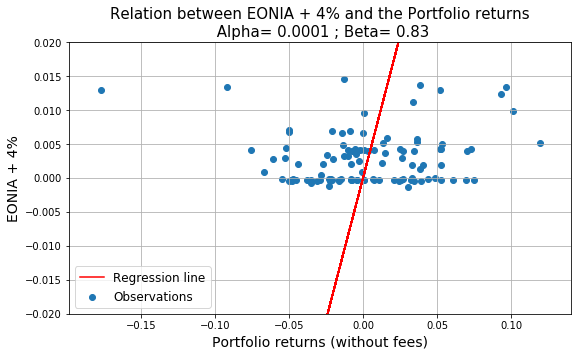

                                   With fees                                    


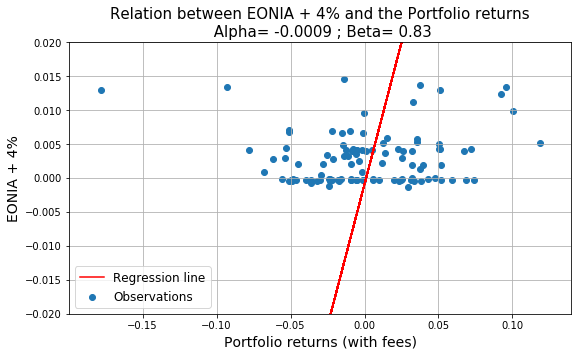

In [30]:
def alpha_beta_coef(x,y,verbose = True):
    
    import statsmodels.api as sm
    from statsmodels import regression
    
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    alpha, beta = model.params[0], model.params[1]
    return alpha, beta

print("Without fees".center(80))
fig= plt.figure(figsize= (9, 5))

a, b= alpha_beta_coef(data["eonia_4"].values, data["effectif"].values)
x= data["effectif"].values
y= data["eonia_4"].values
dated= data["date"].values

plt.scatter(y= y
            , x= x
            , label= "Observations")
plt.plot(x, a + x*b, color= "red", label= "Regression line")
plt.ylim((-0.02, 0.02))
plt.grid()
plt.legend(loc= 3, prop={'size': 12})
plt.title("Relation between EONIA + 4% and the Portfolio returns\n Alpha= {} ; Beta= {}"\
         .format(round(a, 4), round(b, 2)), size= 15)
plt.xlabel("Portfolio returns (without fees)", fontsize= 14)
plt.ylabel("EONIA + 4%", fontsize= 14)
plt.show()

# flemme
print("With fees".center(80))
fig= plt.figure(figsize= (9, 5))
a, b= alpha_beta_coef(data["eonia_4"].values, data2["final_ppt"].values)
x= data2["final_ppt"].values
y= data["eonia_4"].values
dated= data["date"].values

plt.scatter(y= y
            , x= x
            , label= "Observations")
plt.plot(x, a + x*b, color= "red", label= "Regression line")
plt.ylim((-0.02, 0.02))
plt.grid()
plt.legend(loc= 3, prop={'size': 12})
plt.title("Relation between EONIA + 4% and the Portfolio returns\n Alpha= {} ; Beta= {}"\
         .format(round(a, 4), round(b, 2)), size= 15)
plt.xlabel("Portfolio returns (with fees)", fontsize= 14)
plt.ylabel("EONIA + 4%", fontsize= 14)
plt.show()

The fees that were expected to be applied were the following ones:
- Management fees of 1% applied annually
- Performance fees of 20% if the benchmark was beaten annually.

_Starting with management fees we transformed annually fees to monthly installments using $x^{12} = 1.01$ and applied this fee monthly. We tried to do the same with the performance fees but the task was a little bit trickier. We needed to calculate the cumulative product of our series per year meaning that the end of the year will always be December. The following problem appeared, we found that the the first year was only 10 months and the last year was only 11 months, so we thought of using the index of the 12th month to slice our dataset in periods. For each period we calculate the cumprod(annual return) followed by a comparison with the EONIA4 annual return. If our Portfolio performance was higher than the EONIA4, we deduct 20% of the excess return. So simplify our approach as we said earlier, this fee was applied monthly by transforming it in monthly and recreating the initial returns._

_The results were a little bit deceiving since even without deducting the fees we were we weren't even close to beat our benchmark. In annualized total return the EONIA4 was 3.49% lower than the SPX 10.36% but still higher than our Portfolio with and without fees. In total return we managed 18% without fees and by adding the fees we drop as low as 6%. Adding transaction costs would be even worst. The performance will be better shown in the chart below._ 

_Our Alpha was totally destroyed after adding the fees. This was due to our low Alpha initially. Concerning our Beta, we could think that our Portfolio is very correlated to the EONIA4 series (Beta = 0.83). But, when we observed it, we notice in our scatter plot no link between the Portfolio returns without fees and the EONIA4. Indeed, the scatter plot is flat. That's why our regression line is so defective, and shows us an hard relationship._

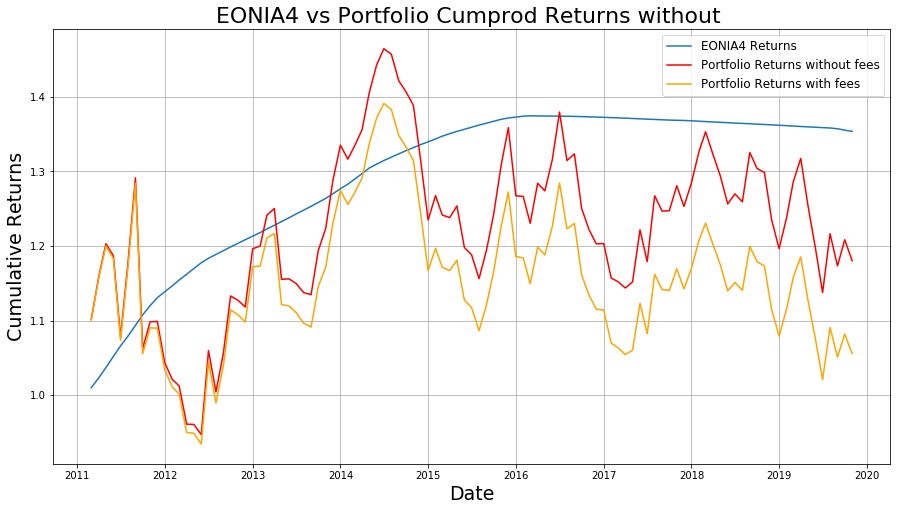

In [31]:
plt.figure(figsize=(15,8))
plt.plot(data.date,(1+data['eonia_4']).cumprod(),label='EONIA4 Returns')
plt.plot(data.date,(1+data['effectif']).cumprod(), c='r', label='Portfolio Returns without fees')
plt.plot(data2.date,(1+data2['final_ppt']).cumprod(), c='orange', label='Portfolio Returns with fees')
plt.title('EONIA4 vs Portfolio Cumprod Returns without ', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Cumulative Returns', fontsize=19)
plt.legend(prop={'size': 12})
plt.grid()
plt.show()

#### 2).

In [32]:
# This function will create windows 
def windows(iterable, n, m=1):
    length = len(iterable)
    i = 0

    while i + n < length:
        yield list(iterable[i:i + n+1])
        i += m

In [33]:
roll_alpha = []
roll_beta = []

for be, al in zip((windows(data["eonia_4"], 36, 1)),(windows(data["effectif"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)

roll_alpha_before= roll_alpha
roll_beta_before= roll_beta

roll_alpha = []
roll_beta = []

for be, al in zip((windows(data2["eonia_4"], 36, 1)),(windows(data2["final_ppt"], 36, 1))):
    alph,be = alpha_beta(be, al,False)
    roll_alpha.append(alph)
    roll_beta.append(be)


- The chart shows the rolling Alpha with a window of 36


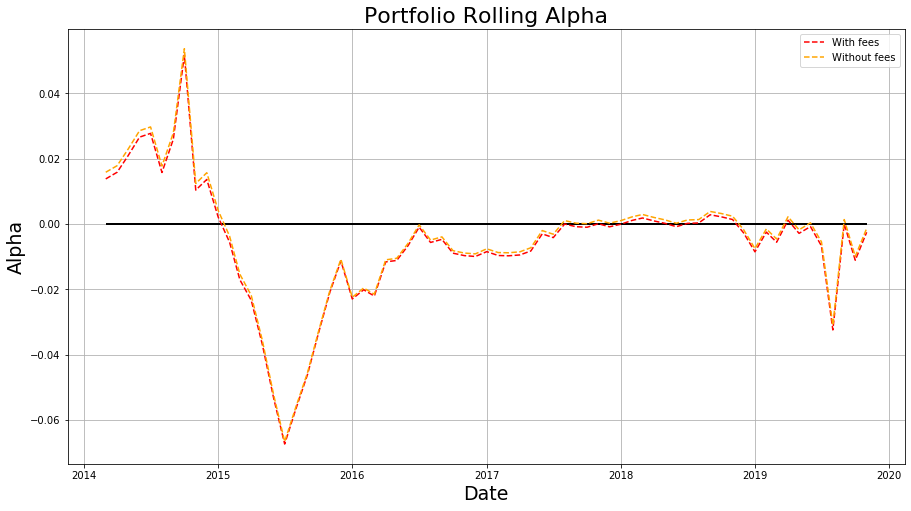

In [34]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_alpha):]
         , roll_alpha, label="With fees"
         , color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_alpha_before):]
         , roll_alpha_before, label='Without fees'
         , color= "orange", linestyle= "--")

plt.hlines(np.repeat(0, len(roll_alpha))
           , xmin= data2.date.values[-len(roll_alpha_before):][0]
           , xmax= data2.date.values[-len(roll_alpha_before):][-1]
           , color= "black"
          )

plt.title('Portfolio Rolling Alpha', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Alpha', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Alpha with a window of 36')
plt.show()


- The chart shows the rolling Beta with a window of 36 points.


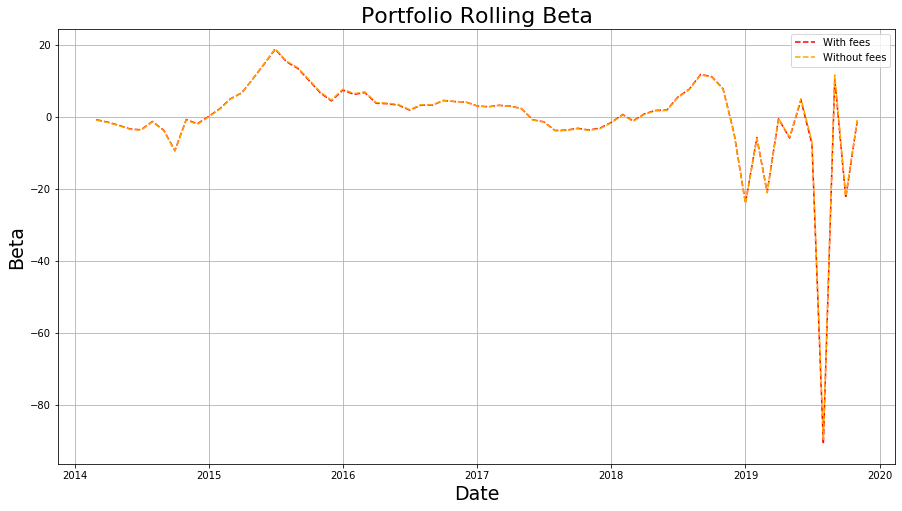

In [35]:
plt.figure(figsize=(15,8))
plt.plot(data2.date.values[-len(roll_beta):]
         , roll_beta, label='With fees', color= "red", linestyle= "--")

plt.plot(data2.date.values[-len(roll_beta_before):]
         , roll_beta_before, label='Without fees', color= "orange", linestyle= "--")

# plt.vlines(ymin= 0.3, ymax= 0.9, x= "2018")

plt.title('Portfolio Rolling Beta', size = 22)
plt.xlabel('Date', fontsize=19)
plt.ylabel('Beta', fontsize=19)
plt.grid()
plt.legend()
print('\n- The chart shows the rolling Beta with a window of 36 points.')
plt.show()

_Our Rolling Alpha remains stable across the two series but the chart shows what we were expecting in late 2015, the sharp drop gave the effects in the late 2017 in the rolling mean chart. Overall we had a good Alpha at the beginning but we couldn't produce a stable positive Alpha during the next years. As we mentioned before, a Short/Long strategy is not the easiest one, especially when we are in a bull run. Finding companies that will under-perform is more difficult than finding companies that will outperform the market, this was better shown with our Long Only Strategy._

_Since the global Beta and the scatter plot shown us an absurde relationship, we are not able to interpret this rolling Beta plotting, noticing those absurde values (-80, -20, 20 etc.)._